In [1]:
!git clone https://github.com/Sridipta-Roy/GenAI-Labs.git

Cloning into 'GenAI-Labs'...
remote: Enumerating objects: 147, done.
remote: Counting objects: 100% (147/147), done.
remote: Compressing objects: 100% (129/129), done.
remote: Total 147 (delta 23), reused 123 (delta 12), pack-reused 0 (from 0)
Receiving objects: 100% (147/147), 34.87 MiB | 16.14 MiB/s, done.
Resolving deltas: 100% (23/23), done.


In [2]:
#Adding for running in Colab
import os
os.chdir('/content/GenAI-Labs/Week_6/Attention')

<center>
    <h1>Attention Mechanism</h1>
</center>

# Brief Recap


**Attention** is a concept in machine learning and AI that goes back many years, especially in computer vision. Like the word "neural network", attention was inspired by the idea of attention in how human brains deal with the massive amount of visual and audio input. **Attention layers** are deep learning layers that evoke the idea of attention.

The most common place you'll see attention layers is in [**transformer**](http://d2l.ai/chapter_attention-mechanisms/transformer.html) neural networks that model sequences. We'll also sometimes see attention in graph neural networks.

$$
Attention(Q,K,V) = softmax(\frac{QK^T}{\sqrt{d_k}})V
$$

Where:

* Q represents the query matrix.
* K represents the key matrix.
* V represents the value matrix.
* $d_k$ is the dimension of the key vectors.
* softmax is the softmax function, which normalizes the attention weights.






# Applications

**Natural Language Processing (NLP)**
* **Machine Translation:** The attention mechanism helps the model focus on relevant parts of the source sentence when generating the target sentence.
* **Text Summarization:** By attending to the most important sentences or phrases, the model can generate concise summaries.
* **Question Answering:** The model can attend to relevant parts of the text to answer questions accurately.
* **Sentiment Analysis:** Understanding the context of words helps the model accurately classify sentiment.

**Computer Vision**
* **Image Captioning:** The model can attend to different parts of the image to generate descriptive captions.
* **Object Detection:** The model can focus on specific regions of the image to identify objects.
* **Image Generation:** The attention mechanism can be used to generate images based on textual descriptions.

**Other Applications**
* **Speech Recognition:** The model can attend to different parts of the audio signal to improve accuracy.
* **Recommendation Systems:** The model can focus on relevant user preferences and item features to make personalized recommendations.
* **Time Series Forecasting:** The model can attend to different time periods to predict future values.


# Implementation of Attention using TensorFlow


We'll implement it step by step using TensorFlow, focusing on the key components:

* **Query, Key, and Value Projections:** These are transformations of input data.
* **Score Calculation:** Compute the attention scores between queries and keys.
* **Softmax Scaling:** Normalize the scores to get attention weights.
* **Weight Application:** Multiply the weights by the values to get the output.



## Approach 1

**Step 1: Calculate the Dot Product**

```
matmul_qk = tf.matmul(query, key, transpose_b=True)
```

 This calculates the similarity or relevance between the query and each key in the input sequence. The resulting matrix `matmul_qk` stores these similarity scores, which are then used in subsequent steps of the attention mechanism to determine the attention weights.

**Step 2: Scale the Scores**<br>
```
depth = tf.cast(tf.shape(key)[-1], tf.float32)
scaled_attention_logits = matmul_qk / tf.math.sqrt(depth)
```
To stabilize gradients during training, we scale the scores by $\sqrt{dk}$ (the dimension of keys). This helps to keep the values of the dot product in a range where the softmax function is effective.

**Step 3: Apply the Mask (Optional)**<br>
The mask is used to prevent certain tokens from being attended to, such as padding tokens. If a position should not be attended to, it is set to a large negative value, making its softmax output near zero.

**Step 4: Apply Softmax**<br>

```
attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
```

The softmax function converts these scores into probabilities, highlighting the most relevant positions for each query. The output is a probability distribution over the sequence length.

**Step 5: Weighted Sum**<br>
```
output = tf.matmul(attention_weights, value)
```

Finally, we multiply these probabilities (attention weights) by the value matrix to get a weighted sum. This weighted sum is the attention output.

In [3]:
import tensorflow as tf
from helpers import *

def scaled_dot_product_attention(query, key, value, mask=None):
    """
    Calculate the attention weights.

    query: shape == (..., seq_len_q, depth)
    key: shape == (..., seq_len_k, depth)
    value: shape == (..., seq_len_v, depth_v)
    mask: shape == (..., seq_len_q, seq_len_k). Defaults to None.

    Returns:
    output: shape == (..., seq_len_q, depth_v)
    attention_weights: shape == (..., seq_len_q, seq_len_k)
    """
    # Step 1: Calculate the dot product between query and key
    matmul_qk = tf.matmul(query, key, transpose_b=True)

    # Step 2: Scale the dot product by the square root of the dimension of the key
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(depth)

    # Step 3: Apply the mask (if provided) to prevent attending to certain positions
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)

    # Step 4: Apply softmax to get the attention weights
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)

    # Step 5: Multiply the weights by the value to get the weighted sum (output)
    output = tf.matmul(attention_weights, value)

    return output, attention_weights


## Example Usage

We'll use the scaled dot-product attention function to **focus on which words in a sequence each query attends to**.

For this demonstration, we'll:

* Tokenize a few sentences.
* Embed them using a simple embedding matrix.
* Use the scaled_dot_product_attention() method on the embedded tokens.
* Visualize the attention weights using a heatmap to show which parts of the input sequence each query focuses on.


### 1. Setup and Preprocessing

We will use a basic tokenizer and TensorFlow to prepare the input sentences:



In [4]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Sample sentences (batch of sentences)
sentences = [
    "I love machine learning",
    "Attention mechanisms are powerful",
    "Transformers have changed NLP",
    "Deep learning is amazing"
]

# Create a basic word-to-index mapping (tokenizer)
vocab = {word: idx for idx, word in enumerate(set(' '.join(sentences).lower().split()), 1)}
vocab_size = len(vocab) + 1  # +1 for padding token

# Function to tokenize a sentence and convert to indices
def tokenize(sentence):
    return [vocab[word.lower()] for word in sentence.split()]

# Convert each sentence into indices and pad them to equal length
tokenized_sentences = [tokenize(sentence) for sentence in sentences]
max_len = max(len(sentence) for sentence in tokenized_sentences)
padded_sentences = tf.keras.preprocessing.sequence.pad_sequences(
    tokenized_sentences, maxlen=max_len, padding='post'
)

print("Padded Sentences (Tokenized):\n", padded_sentences)

Padded Sentences (Tokenized):
 [[ 2  1 13  8]
 [15  3  4 12]
 [14  5  6  7]
 [ 9  8 10 11]]


### 2. Embedding and Attention Calculation
Let's use an embedding layer to convert tokenized inputs into dense vectors:



In [5]:
# Step 2: Create an Embedding Layer to get dense representations of tokens
embedding_dim = 8  # Embedding dimension
embedding_layer = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim)

# Get the embedded representations for each token in each sentence
embedded_sentences = embedding_layer(padded_sentences)

# Step 3: Use the same embeddings as queries, keys, and values for simplicity
query = embedded_sentences
key = embedded_sentences
value = embedded_sentences

# Calculate the attention output and weights using the scaled_dot_product_attention function
output, attention_weights = scaled_dot_product_attention(query, key, value)

print("Attention Weights Shape:", attention_weights.shape)  # (batch_size, seq_len, seq_len)


Attention Weights Shape: (4, 4, 4)


### 3. Visualizing Attention Weights
We can plot the attention weights to see which words each token focuses on:



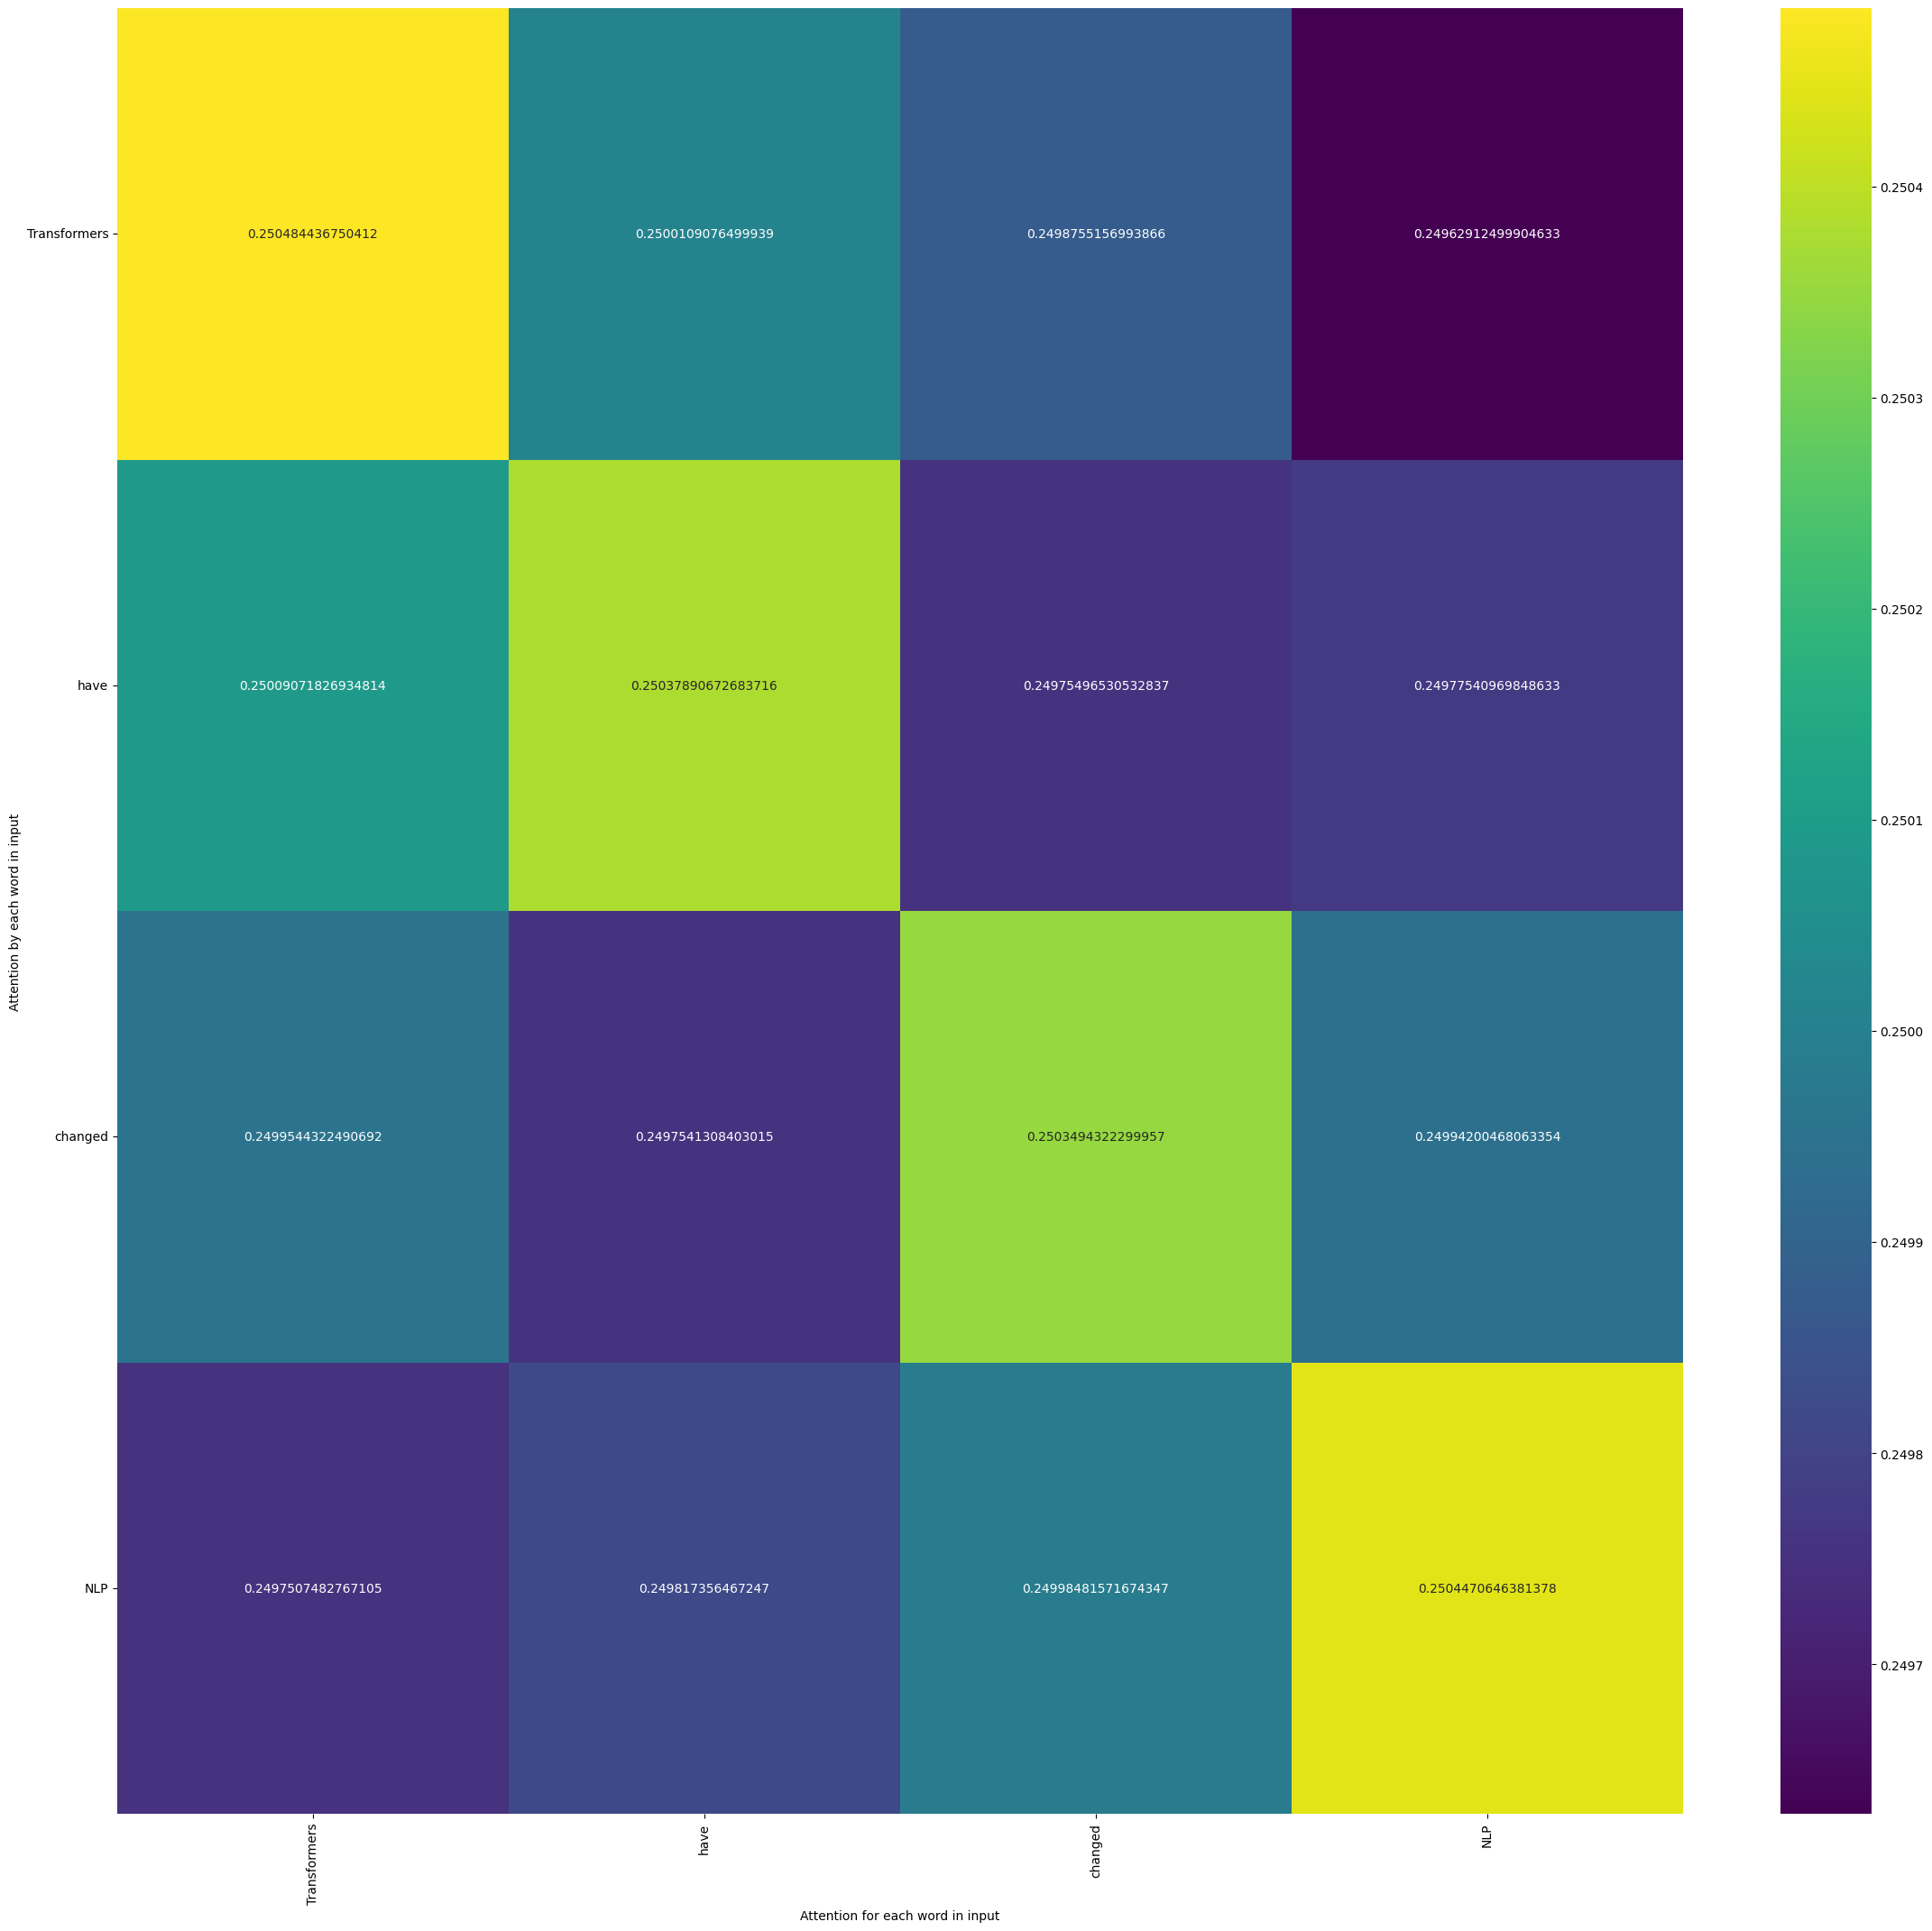

In [6]:
# Select a sentence to visualize (e.g., first sentence)
sentence_idx = 2
original_sentence = sentences[sentence_idx].split()

# Step 4: Plot the attention weights for the selected sentence
plot_attention_weights(attention_weights.numpy(), original_sentence, sentence_idx)


Checkout this [notebook](https://colab.research.google.com/drive/1hXIQ77A4TYS4y3UthWF-Ci7V7vVUoxmQ?usp=sharing) for more interesting visualizations of attention weights.

## Approach 2

Although, the above approach gives you more control in designing your attention mechanism, there is an alternate and more simpler way to do that.

TensorFlow provides built-in layers for implementing attention mechanisms. Here's how you can implement attention using Keras APIs:

```
tf.keras.layers.Attention(use_scale=True, score_mode='dot')
```


**Arguments:**

* **use_scale:** (Boolean, defaults to False) If True, will create a scalar variable to scale the attention scores. This can help stabilize the training process.
* **causal:** (Boolean, defaults to False) If True, the attention mask will be a lower triangular matrix, preventing the model from attending to future positions in the sequence. This is often used in autoregressive models.
* **dropout:** (Float, defaults to 0.0) The dropout rate to apply to the attention scores. Dropout can help prevent overfitting.

**Call arguments:**

* `inputs:` A list containing the following tensors:
  * `query:` Tensor of shape (..., seq_len_q, depth) representing the query.
  * `value:` Tensor of shape (..., seq_len_v, depth_v) representing the value.
  * `key:` (Optional) Tensor of shape (..., seq_len_k, depth) representing the key. If not provided, the value tensor will be used as the key.
* `mask:` (Optional) A list containing the following tensors:
  * `query_mask`: A boolean mask of shape (..., seq_len_q) indicating which query positions are valid.
  * `value_mask`: A boolean mask of shape (..., seq_len_v) indicating which value positions are valid.
* `return_attention_scores:` (Boolean, defaults to False) If True, the layer will return the attention scores along with the output.

**Outputs:**

* **output:** Tensor of shape (..., seq_len_q, depth_v) representing the attention output.
* **attention_scores:** (Optional) If return_attention_scores=True, the layer will also return a tensor of shape (..., seq_len_q, seq_len_v) representing the attention scores.




---

# Sentiment Analysis using Attention Mechanisms


We investigate the use of attention mechanism that allows a model to attend to different positions within the same input sequence, to capture the relationships between words and improve sentiment classification performance. We demonstrate the effectiveness of this approach on a benchmark sentiment analysis dataset and compare it to traditional methods. Our findings highlight the potential of attention mechanisms to enhance the accuracy and robustness of sentiment analysis models.


## Dataset Description

The [**Yelp Review Full dataset**](https://www.yelp.com/dataset) is a collection of Yelp reviews, specifically designed for text classification tasks, especially sentiment analysis.

**Key characteristics:**

* **Content:** Contains reviews from Yelp users about various businesses.
Labels: Each review is associated with a star rating (1-5), used as the basis for sentiment labels (positive/negative). Reviews with ratings of 4 or 5 are labeled positive, while reviews with ratings less than 4 are negative.
* **Size:** The full dataset is quite large. The provided code uses 30,000 samples for training and 6,000 for testing for demonstration purposes.
* **Format:** The data is stored as text, and the code uses a tokenizer to convert words into numerical representations.



In [7]:
import pandas as pd
import numpy as np
from tensorflow.keras.layers import Dense, Embedding, LSTM, Bidirectional, Input, Layer, Attention, GlobalAveragePooling1D
from tensorflow.keras.models import Model
from datasets import load_dataset
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

## Loading and preprocessing the dataset

* We use `datasets` library to load the Yelp Review Full dataset.
* We preprocesses the labels by assuming a positive sentiment for ratings 4 and above, and negative otherwise.
* Then we split the dataset into training and testing sets using `train_test_split`.
* Reviews are tokenized using `Tokenizer` and padded using `pad_sequences` to ensure uniform input length for the model.

In [8]:
# Load the Yelp Reviews dataset
dataset = load_dataset("yelp_review_full")

# Loading just 30k records
df = pd.DataFrame(dataset['train'])[:30000]


README.md: 0.00B [00:00, ?B/s]

yelp_review_full/train-00000-of-00001.pa(…):   0%|          | 0.00/299M [00:00<?, ?B/s]

yelp_review_full/test-00000-of-00001.par(…):   0%|          | 0.00/23.5M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/650000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [9]:
# Preprocess labels: Let's assume sentiment is positive for ratings >= 4, negative for < 4.
df['sentiment'] = df['label'].apply(lambda x: 1 if x >= 4 else 0)

# Split the dataset into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(df['text'], df['sentiment'], test_size=0.2, random_state=42)

In [10]:
# Tokenize the reviews
max_features = 10000  # Max number of words to consider in the tokenizer
max_len = 100  # Max length of sequences

tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(x_train)

In [11]:

x_train_tokens = tokenizer.texts_to_sequences(x_train)
x_test_tokens = tokenizer.texts_to_sequences(x_test)

# Pad sequences to ensure uniform input length
x_train_tokens = pad_sequences(x_train_tokens, maxlen=max_len)
x_test_tokens = pad_sequences(x_test_tokens, maxlen=max_len)

## Model Building

* We add an **embedding layer** to convert tokenized inputs into dense vectors.
* Then, a **bidirectional LSTM** **(Long Short-Term Memory)** layer processes the embedded sequences.
* The core of the model is the **Attention** layer from TensorFlow, applied to the outputs of the **LSTM** layer. This layer calculates attention weights to identify important parts of the review for sentiment classification.
* A **global average pooling** layer aggregates the attention outputs into a single vector.
* Finally, a dense layer with a **sigmoid** activation function predicts the sentiment (positive or negative).

In [12]:
# Build the model using TensorFlow's built-in Attention layer
input = Input(shape=(max_len,))
embedding = Embedding(max_features, 128, input_length=max_len)(input)
bi_lstm = Bidirectional(LSTM(64, return_sequences=True))(embedding)

# Add Attention layer
# Query, Key, and Value are the same in this case.
attention_output, attention_score = Attention()([bi_lstm, bi_lstm], return_attention_scores=True)

# GlobalAveragePooling1D is used to aggregate the attention outputs into a single vector
attention_output = GlobalAveragePooling1D()(attention_output)

# Create the model with a single output
output = Dense(1, activation='sigmoid')(attention_output)

model = Model(inputs=input, outputs=output)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [13]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 100, 128)  │  1,280,000 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 100, 128)  │     98,816 │ embedding_1[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ [(None, 100,      │          0 │ bidirectional[0]… │
│ (Attention)         │ 128), (None, 100, │            │ bidirectional[0]… │
│                     │ 100)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ attention[0][0]   │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │        129 │ global_average_p… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,378,945 (5.26 MB)

 Trainable params: 1,378,945 (5.26 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(x_train_tokens, y_train, batch_size=128, epochs=20, validation_split=0.2)

# Evaluate the model
loss, accuracy = model.evaluate(x_test_tokens, y_test)
print(f'Test Accuracy: {accuracy:.2f}')

Epoch 1/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.8126 - loss: 0.4871 - val_accuracy: 0.8329 - val_loss: 0.3523
Epoch 2/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.8581 - loss: 0.3099 - val_accuracy: 0.8612 - val_loss: 0.3368
Epoch 3/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.8929 - loss: 0.2616 - val_accuracy: 0.8629 - val_loss: 0.3119
Epoch 4/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9046 - loss: 0.2230 - val_accuracy: 0.8571 - val_loss: 0.3433
Epoch 5/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9283 - loss: 0.1808 - val_accuracy: 0.8587 - val_loss: 0.3784
Epoch 6/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9421 - loss: 0.1450 - val_accuracy: 0.8548 - val_loss: 0.4278
Epoch 7/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9517 - loss: 0.1215 - val_accuracy: 0.8485 - val_loss: 0.4751
Epoch 8/20
150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9634 - loss: 0.0884 - val_accu

## Evalutation and Inference

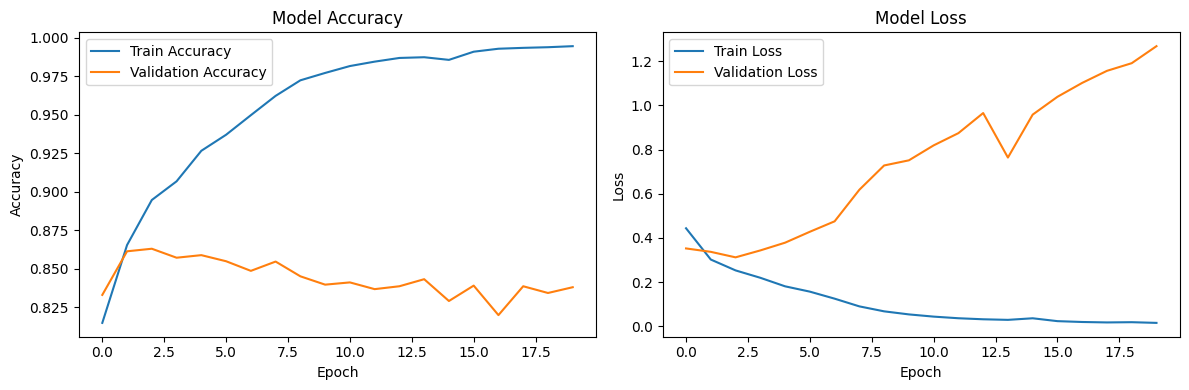

In [15]:
plot_metrics(history)

## Visualize Attention Weights

In [16]:
test = x_train[4]
x_test_tokens = tokenizer.texts_to_sequences([test])

# Pad sequences to ensure uniform input length
x_test_tokens = pad_sequences(x_test_tokens, maxlen=100)

In [18]:
input_data = np.expand_dims(x_test_tokens[0], axis=0)  # Add batch dimension

attention_output, attention_score = model.get_layer("attention").output

intermediate_model = Model(inputs = input, outputs = attention_score)

attention_score_output = intermediate_model.predict(input_data)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step


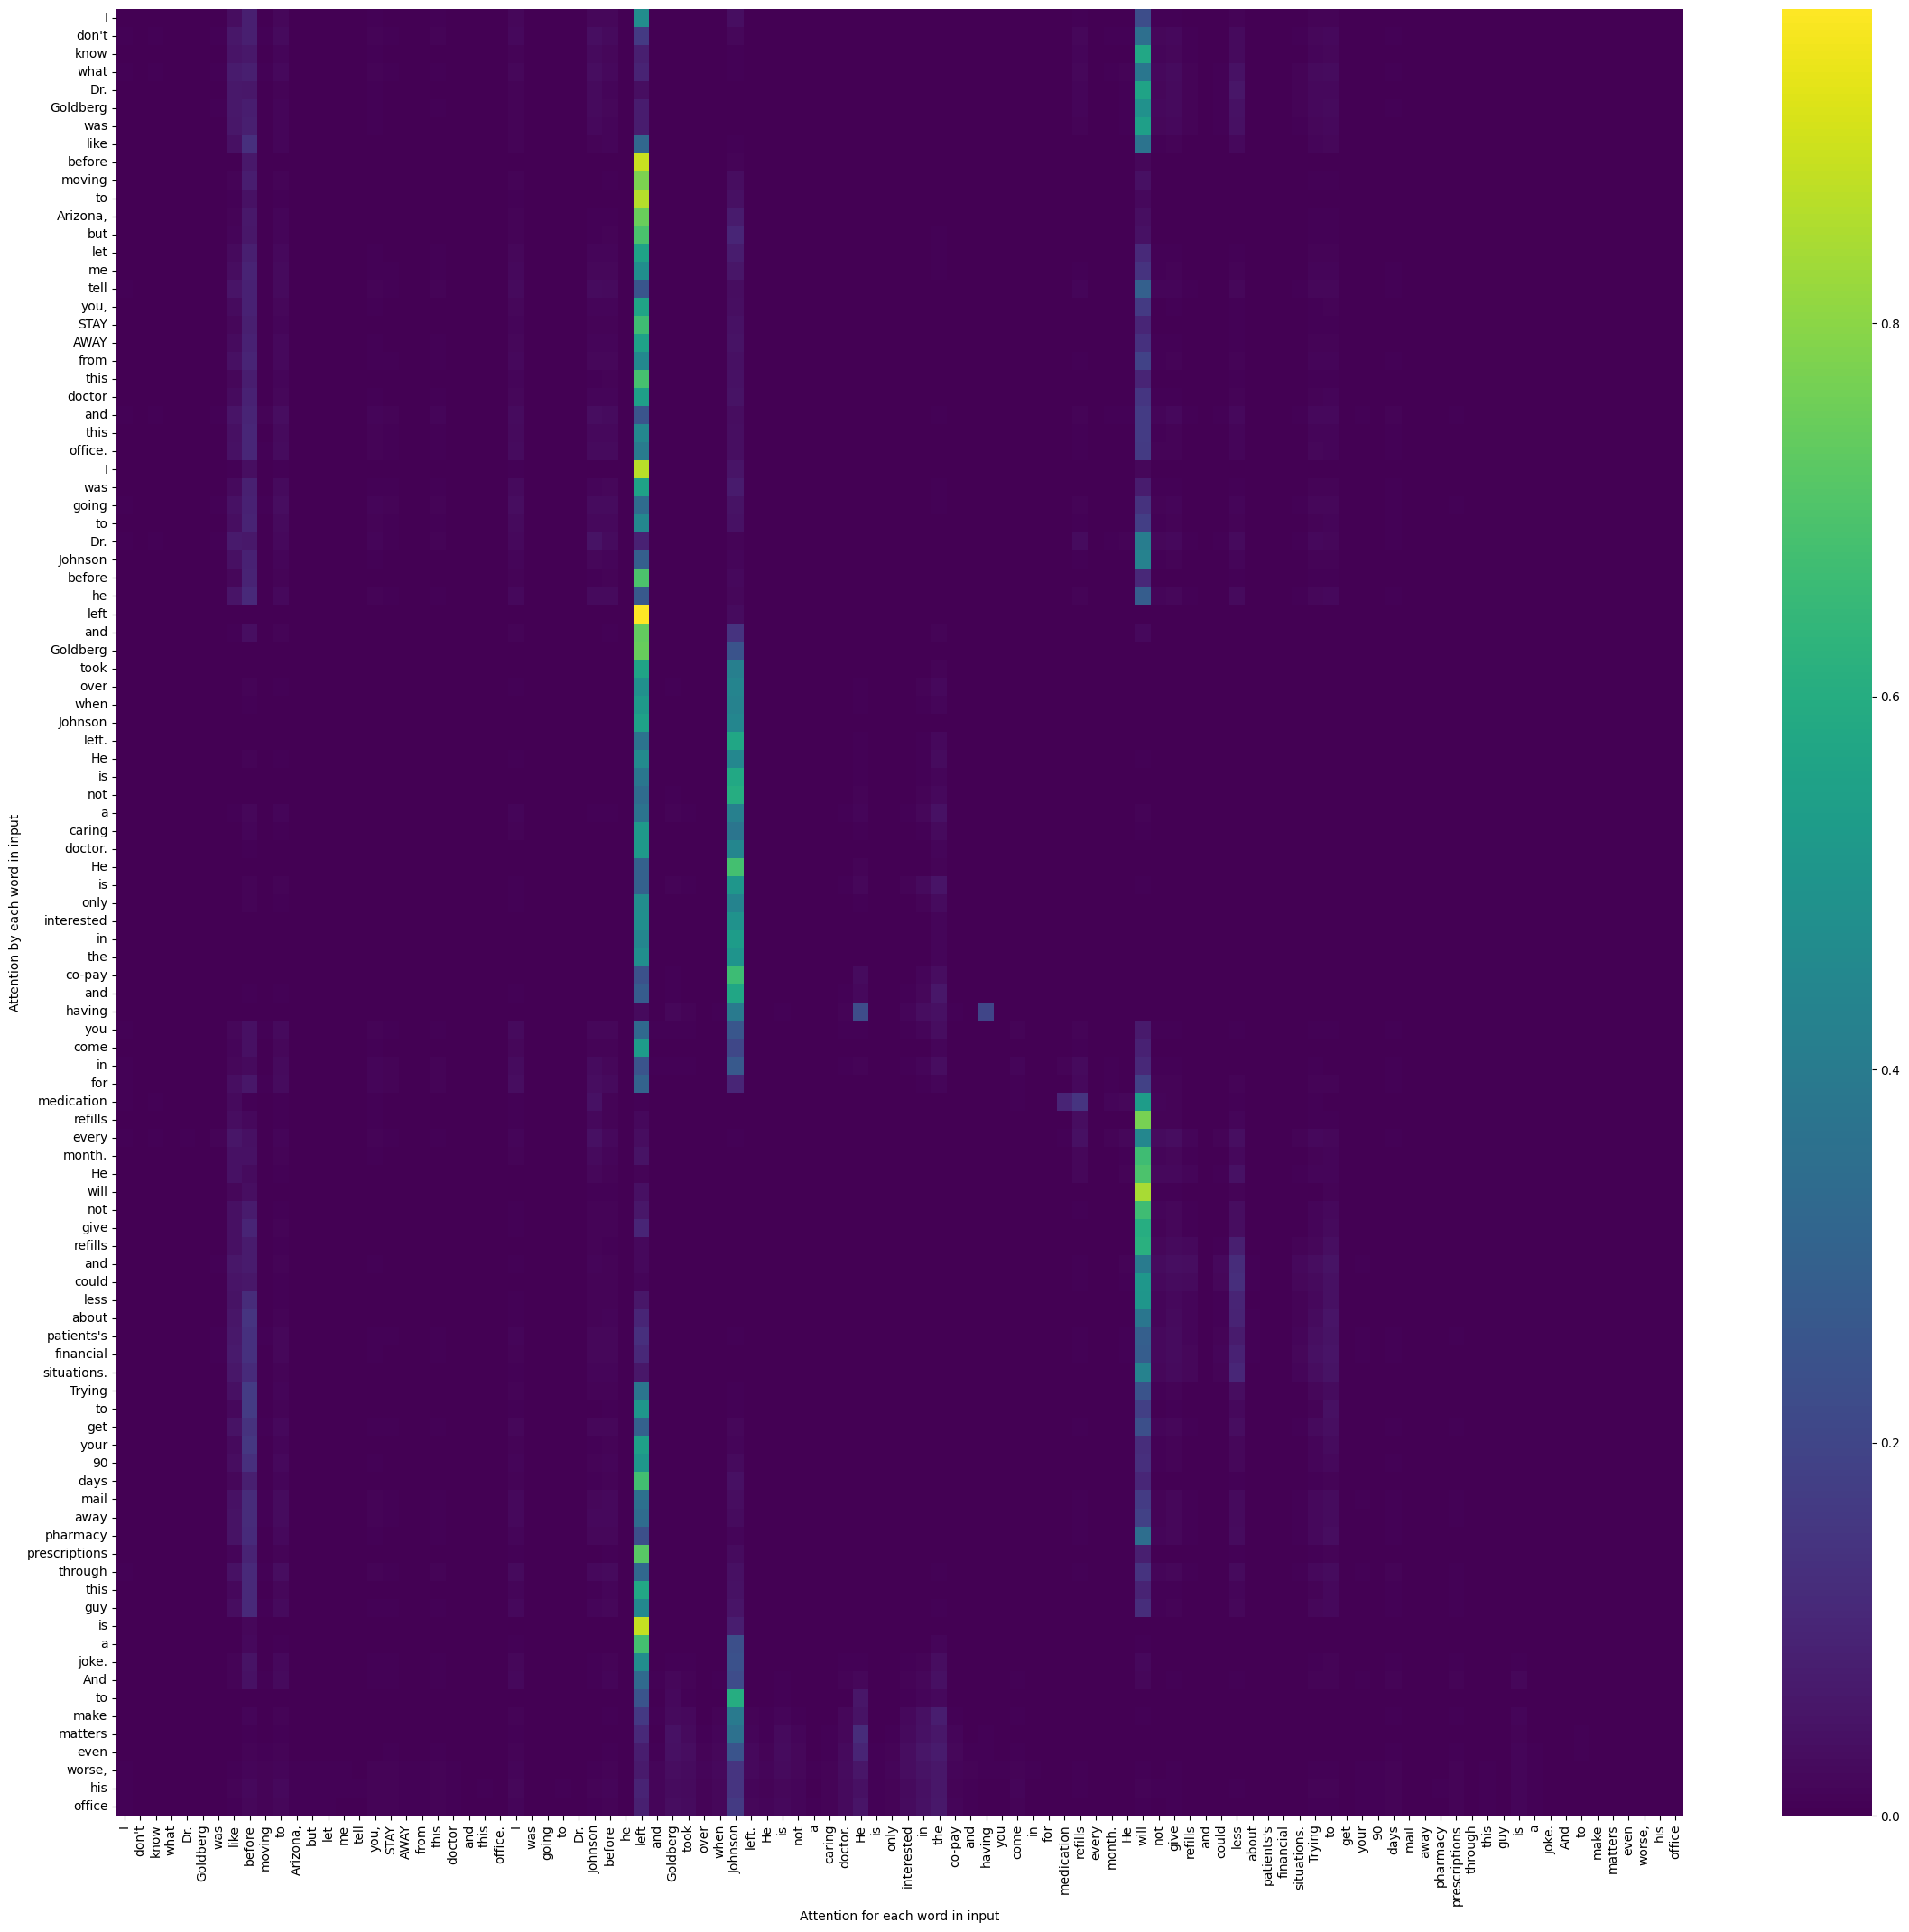

In [19]:
plot_attention_weights(attention_score_output[0], test.split()[:100], annotate=False)

In [20]:
# Function to predict sentiment
def predict_sentiment(model, text, max_len):
    """Predicts the sentiment of a given text using the trained model.

    Args:
        model: The trained sentiment analysis model.
        text: The input text for sentiment prediction.

    Returns:
        A tuple containing the predicted sentiment ("Positive" or "Negative")
        and the confidence score (a value between 0 and 1).
    """
    # Preprocess the input text
    preprocessed_text = preprocess_input_text(text, tokenizer, max_len)
    # Predict the sentiment using the trained model
    prediction = model.predict(preprocessed_text)[0][0]
    # Convert the prediction into a label
    if prediction >= 0.5:
        sentiment = "Positive"
    else:
        sentiment = "Negative"
    return sentiment, prediction

# Example usage:
review = "The food was not that great!"
sentiment, confidence = predict_sentiment(model, review, max_len)
print(f'Review: "{review}"')
print(f'Sentiment: {sentiment} (Confidence: {confidence:.2f})')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
Review: "The food was not that great!"
Sentiment: Negative (Confidence: 0.01)


# Improvement Strategies

1. **Hyperparameter Tuning:**

* **Experiment with different embedding dimensions:** Try increasing or decreasing the embedding dimension (embedding_dim) to see if it improves performance.
* **Adjust LSTM units:** Explore different numbers of units in the LSTM layers.
* **Optimize batch size and epochs:** Fine-tune the batch size and number of training epochs for better convergence.
Try different optimizers: Consider using other optimizers like RMSprop or SGD.

2. **Regularization:**

* **Add dropout:** Introduce dropout layers to prevent overfitting. You can add them after the embedding layer or the LSTM layer.
Apply L1/L2 regularization: Consider adding regularization to the dense layers.

3. **Pre-trained Embeddings:**

* **Use pre-trained word embeddings:** Instead of training embeddings from scratch, leverage pre-trained word embeddings like GloVe or Word2Vec. These embeddings capture semantic relationships between words and can improve performance.

4. **Advanced Architectures:**

* **Transformer-based models:** Explore using pre-trained transformer models like BERT or RoBERTa. These models have shown state-of-the-art results in various NLP tasks, including sentiment analysis.
* **Hierarchical attention:** Implement hierarchical attention mechanisms to capture relationships at different levels of the text, such as word-level and sentence-level.

5. **Data Augmentation:**

* **Back translation:** Translate reviews to another language and then back to the original language to create synthetic data.
* **Synonym replacement:** Replace words with their synonyms to increase data diversity.

6. **Handling Class Imbalance:**

* If the dataset has a significant class imbalance (e.g., more positive reviews than negative reviews), consider techniques like oversampling the minority class or using weighted loss functions.

